# Imports

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import datetime as dt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

from matplotlib import pyplot as plt
from matplotlib import cm as cmap
import matplotlib

# Pull Data

## Get the Facial Expression and Joystick Label Data

In [2]:
participants = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
videos = {'1': 'neutral', '2': 'positive', '3': 'neutral', '4': 'negative'}

pi_df = pd.DataFrame()
for participant in participants:
    for video in videos.keys():
        try:
            tmp = pd.read_fwf(f'ubi_data/p{participant}_v{video}.txt', header=None)
            tmp_df = tmp[(tmp.index > 94) &
                         (tmp.index < len(tmp.index) - 44)][0].str.split(', ', expand=True)
            data_cols = ['timestamp', 'x_joystick', 'y_joystick', 'pred_emotion', 'emotion_confidence']
            tmp_df.columns = data_cols
            tmp_df['participant_id'] = participant
            tmp_df['video_id'] = video
            tmp_df['video_type'] = videos[video]
            tmp_df = tmp_df[['timestamp','participant_id','video_id','video_type'] + data_cols[1:]]

            pi_df = pd.concat([pi_df, tmp_df])
        except:
            print(f'Bad data for participant {participant} and video {video}')
            
pi_df = pi_df.reset_index(drop=True)

# Remove data that doesn't exist in the vital signs
pi_df = pi_df[~((pi_df['participant_id'] == '5') & (pi_df['video_id'] == '3'))]

pi_df = pi_df[~((pi_df['timestamp'].str.contains('jpegout')) |
                (pi_df['timestamp'].str.contains('Opening')) |
                (pi_df['timestamp'].str.contains('Attempting')) |
                (pi_df['timestamp'].str.contains('Starting')) |
                (pi_df['timestamp'].str.contains('Successfully')))]
pi_df['timestamp'] = pd.to_datetime(pi_df['timestamp'].astype(float), unit='s').apply(lambda x: x - dt.timedelta(hours=4))
pi_df['rounded_ts'] = pi_df.timestamp.astype(str).apply(lambda x: x.split('.')[0])
pi_df['x_joystick'] = (-1 * (pi_df['x_joystick'].astype(int) - 500)) / 500
del pi_df['timestamp']
del pi_df['y_joystick']

Bad data for participant 2 and video 1
Bad data for participant 4 and video 1
Bad data for participant 5 and video 4
Bad data for participant 7 and video 2


## Get the Respiration and Movement Data

In [3]:
br_df = pd.DataFrame()
for participant in participants:
    for video in videos.keys():
        try:
            tmp = pd.read_fwf(f'vitalsigns/p{participant}_v{video}.csv', header=None)
            tmp = tmp[(tmp.index > 13)].reset_index(drop=True)[0].str.split(';', expand=True)
            tmp.columns = list(tmp[tmp.index == 0].values)[0]
            tmp = tmp[tmp.index > 0].reset_index(drop=True).replace('nan', '-1')
            tmp['RPM'] = tmp['RPM'].replace('0', np.nan).astype(float)
            tmp['Distance'] = tmp['Distance'].astype(float)
            tmp['NormalizedMovementSlow'] = tmp['NormalizedMovementSlow'].astype(float)
            tmp['NormalizedMovementFast'] = tmp['NormalizedMovementFast'].astype(float)
            tmp['NormalizedMovementStart'] = tmp['NormalizedMovementStart'].astype(float)
            tmp['NormalizedMovementEnd'] = tmp['NormalizedMovementEnd'].astype(float)
            tmp = tmp[['TimeStamp','RPM','Distance','NormalizedMovementSlow','NormalizedMovementFast','NormalizedMovementStart','NormalizedMovementEnd']]
            data_cols = ['timestamp','rpm','distance','norm_slow','norm_fast','norm_start','norm_stop']
            tmp.columns = data_cols
            tmp['timestamp'] = pd.to_datetime(tmp['timestamp'])

            tmp['participant_id'] = participant
            tmp['video_id'] = video
            tmp['video_type'] = videos[video]

            tmp = tmp[['timestamp','participant_id','video_id','video_type'] + data_cols[1:]]

            br_df = pd.concat([br_df, tmp])
        except:
            print(f'Bad data for participant {participant} and video {video}')
        
br_df = br_df.reset_index(drop=True)
br_df['rounded_ts'] = br_df.timestamp.astype(str).apply(lambda x: x.split('.')[0])
del br_df['timestamp']

Bad data for participant 2 and video 1
Bad data for participant 4 and video 1
Bad data for participant 5 and video 3
Bad data for participant 5 and video 4
Bad data for participant 7 and video 2


# Merge the Data

In [4]:
data_df = pi_df.merge(br_df, how='inner', on=['participant_id','video_id','video_type','rounded_ts'])

In [5]:
starter_cols = ['rounded_ts','participant_id','video_id','video_type']
other_cols = [x for x in list(data_df.columns) if x not in starter_cols]
data_df = data_df[starter_cols + other_cols]
data_df = data_df.dropna()

# Visualize Distributions

## Participant Data Representation

In [6]:
count_df = data_df.groupby('participant_id').video_id.count().reset_index().rename(columns={'video_id': 'count'})
fig = px.bar(count_df, x='participant_id', y='count',
             title='Participant Data Distribution',
             labels={'count': 'Number of Data Points',
                     'participant_id': 'Participant ID'},
             template='ggplot2')
fig.show()

## Distribution of User Reported Emotions

In [7]:
bins = [-1.5, -0.75, -0.5, -0.25, -0.1, 0.1,
        0.25, 0.5, 0.75, 1.5]
labels = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Neutral','Positive','Negative'))
emotions = ['neutral','positive','negative']
for i, emotion in enumerate(emotions):
    tmp = data_df[data_df['video_type'] == emotion]
    tmp['x_joystick'] = pd.cut(tmp['x_joystick'], bins=bins, labels=labels)
    tmp = tmp.groupby('x_joystick').video_id.count().reset_index().rename(columns={'video_id':'count'})
    fig.add_trace(go.Bar(x=list(tmp['x_joystick']),
                         y=list(tmp['count'])),
                  row=1, col=i + 1)

fig.update_layout(title_text='User-Reported Emotion by Video Type', showlegend=False)
fig.update_yaxes(title_text='Count of Reported Emotions', row=1, col=1)
fig.update_xaxes(title_text='Negative to Positive Reported Emotions', row=1, col=2)
fig.show()

<ipython-input-7-e86b86564502>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## RPM Distribution 

In [8]:
bins = [6, 9, 12, 15, 16.5, 19.5, 21, 24, 27, 30]
labels = [6, 9, 12, 15, 18, 21, 24, 27, 30]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Neutral','Positive','Negative'))
emotions = ['neutral','positive','negative']
for i, emotion in enumerate(emotions):
    tmp = data_df[data_df['video_type'] == emotion]
    tmp['rpm'] = pd.cut(tmp['rpm'], bins=bins, labels=labels)
    tmp = tmp.groupby('rpm').video_id.count().reset_index().rename(columns={'video_id':'count'})
    fig.add_trace(go.Bar(x=list(tmp['rpm']),
                         y=list(tmp['count'])),
                  row=1, col=i + 1)

fig.update_layout(title_text='RPM by Video Type', showlegend=False)
fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_xaxes(title_text='Respiration Rate', row=1, col=2)
fig.show()

<ipython-input-8-a7ce55519c6c>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Predicted Emotion Distribution

In [9]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Neutral','Positive','Negative'))
emotions = ['neutral','positive','negative']
for i, emotion in enumerate(emotions):
    tmp = data_df[data_df['video_type'] == emotion]
    tmp = tmp.groupby('pred_emotion').video_id.count().reset_index().rename(columns={'video_id':'count'})
    fig.add_trace(go.Bar(x=list(tmp['pred_emotion']),
                         y=list(tmp['count'])),
                  row=1, col=i + 1)

fig.update_layout(title_text='Predicted Emotion by Video Type', showlegend=False)
fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_xaxes(title_text='Predicted Emotion', row=1, col=2)
fig.show()

## Show Emotion Confidence by Predicted Emotion and Video Type

In [10]:
bins = [0.7, 0.75, 0.8, 0.825, 0.875, 0.9, 0.95, 1.0]
labels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


fig = make_subplots(rows=5, cols=3,
                    subplot_titles=('Neutral','Positive','Negative'))
emotions = ['neutral','positive','negative']
colors = ['blue', 'green', 'red']
for i, emotion in enumerate(emotions):
    tmp = data_df[data_df['video_type'] == emotion]
    for j, pred_emotion in enumerate(data_df['pred_emotion'].unique()):
        tmp2 = tmp[tmp['pred_emotion'] == pred_emotion]
        
        tmp2['emotion_confidence'] = pd.cut(tmp['emotion_confidence'].astype(float), bins=bins, labels=labels)
        grp = tmp2.groupby('emotion_confidence').video_id.count().reset_index().rename(columns={'video_id':'count'})
        fig.add_trace(go.Bar(x=list(grp['emotion_confidence']),
                             y=list(grp['count']),
                             marker = {'color' : colors[i]}),
                      row=j + 1, col=i + 1)
        if i == 0:
            fig.update_yaxes(title_text=pred_emotion.title(), row=j + 1, col=1)

fig.update_layout(title_text='Emotion Confidence by Video Type and Predicted Emotion', showlegend=False,
                 height=1000)
fig.update_xaxes(title_text='Emotion Confidence', row=5, col=2)
fig.show()

<ipython-input-10-ba9ff5c85489>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Classify Video Type

## Encode Categorical Data

In [11]:
label_encoding = dict(zip(data_df['video_type'].unique(), range(0,3)))
data_df['enc_video_type'] = data_df['video_type'].map(label_encoding, na_action='ignore')

emotion_encoding = dict(zip(data_df['pred_emotion'].unique(), range(0, len(data_df['pred_emotion'].unique()))))
data_df['enc_pred_emotion'] = data_df['pred_emotion'].map(emotion_encoding, na_action='ignore')

## Prep Data for Features/Labels

In [12]:
features = ['enc_pred_emotion','emotion_confidence','rpm','distance','norm_slow','norm_fast','norm_start','norm_stop']

X = data_df[features].astype(float)
y = data_df['enc_video_type']

## Build Classifier

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

1.0


## Find Feature Importance

In [14]:
# See which features were most important
imps = pd.DataFrame()
imps['Features'] = features
imps['Importances'] = clf.feature_importances_
imps = imps.sort_values('Importances', ascending=False)
px.bar(imps, x='Features', y='Importances', template='ggplot2',
       title='Feature Importance')

## Analyze Classification Effectiveness

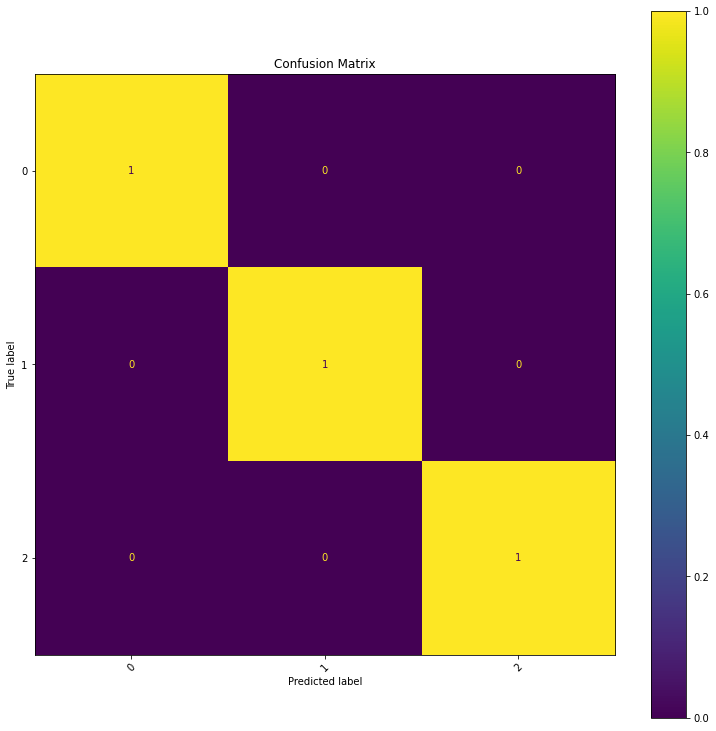

In [15]:
# Show the confusion matrix
fig, ax = plt.subplots(figsize=(13, 13))
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=cmap.get_cmap('viridis'),
                             normalize='true',
                             ax=ax)
disp.ax_.set_title('Confusion Matrix')
plt.xticks(rotation=45)
matplotlib.rcParams.update({'font.size': 13})

plt.show()

In [16]:
cm = disp.confusion_matrix
prec_sum = 0
recall_sum = 0

for i, label in enumerate(['neutral','positive','negative']):
    col_sum = 0
    row_sum = 0
    for j, _ in enumerate(['neutral','positive','negative']):
        col_sum += cm[i][j]
        row_sum += cm[j][i]
        if i == j:
            true_val = cm[i][j]
    if col_sum == 0:
        col_sum = 1
    if row_sum == 0:
        row_sum = 1
    prec_sum += true_val / col_sum
    recall_sum += true_val / row_sum
    
precision = prec_sum / len(['neutral','positive','negative'])
recall = recall_sum / len(['neutral','positive','negative'])

print(f'The average precision is: {round(precision, 4)} and recall is: {round(recall, 4)}')

The average precision is: 1.0 and recall is: 1.0


# Regress to Emotion Level

## Separate Data for Features/Labels

In [17]:
features = ['enc_pred_emotion','emotion_confidence','rpm','distance','norm_slow','norm_fast','norm_start','norm_stop']

X = data_df[features].astype(float)
y = data_df['x_joystick']

## Build the Regressor

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

regr = RandomForestRegressor(max_depth=8)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

y_hat = regr.predict(X)

0.8990197080408268


## Show Feature Importance

In [19]:
# See which features were most important
imps = pd.DataFrame()
imps['Features'] = features
imps['Importances'] = clf.feature_importances_
imps = imps.sort_values('Importances', ascending=False)
px.bar(imps, x='Features', y='Importances', template='ggplot2',
       title='Feature Importance')

## Analyze Regressor Effectiveness

In [20]:
# Adding y_hat to data_df
data_df['y_hat'] = y_hat.tolist()

bins = [-1.5, -0.75, -0.5, -0.25, -0.1, 0.1,
        0.25, 0.5, 0.75, 1.5]
labels = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Neutral','Positive','Negative'))
emotions = ['neutral','positive','negative']
for i, emotion in enumerate(emotions):
    tmp = data_df[data_df['enc_video_type'] == label_encoding[emotion]]
    tmp['y_hat'] = pd.cut(tmp['y_hat'], bins=bins, labels=labels)
    tmp = tmp.groupby('y_hat').video_id.count().reset_index().rename(columns={'video_id':'count'})
    fig.add_trace(go.Bar(x=list(tmp['y_hat']),
                         y=list(tmp['count'])),
                  row=1, col=i + 1)

fig.update_layout(title_text='Predicted Emotion Level by Video Type', showlegend=False)
fig.update_yaxes(title_text='Count', row=1, col=1)
fig.update_xaxes(title_text='Negative to Positive Predicted Emotions', row=1, col=2)
fig.show()

<ipython-input-20-fa71736731f7>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-fa71736731f7>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-fa71736731f7>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
y_hat = regr.predict(X_test)
fig = px.histogram(x=y_hat,
                   title='Test Predicted Emotion Range',
                   labels={'x': 'Predicted Emotion Strength'},
                   template='ggplot2')
fig.show()

## Emotion RPM versus Neutral RPM

<ipython-input-22-9a9f041dab6e>:19: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



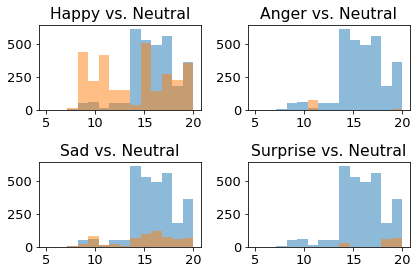

In [22]:
bins = np.linspace(5,20,15)

fig, axs = plt.subplots(2,2)

axs[0,0].hist(data_df.loc[data_df['pred_emotion']=='neutral']['rpm'], bins, alpha=0.5)#, label='Neutral RPM')
axs[0,1].hist(data_df.loc[data_df['pred_emotion']=='neutral']['rpm'], bins, alpha=0.5)#, label='Neutral RPM')
axs[1,0].hist(data_df.loc[data_df['pred_emotion']=='neutral']['rpm'], bins, alpha=0.5)#, label='Neutral RPM')
axs[1,1].hist(data_df.loc[data_df['pred_emotion']=='neutral']['rpm'], bins, alpha=0.5)#, label='Neutral RPM')

axs[0,0].hist(data_df.loc[data_df['pred_emotion']=='happy']['rpm'], bins, alpha=0.5)#, label='Happy RPM')
axs[0,0].set_title('Happy vs. Neutral')
axs[0,1].hist(data_df.loc[data_df['pred_emotion']=='anger']['rpm'], bins, alpha=0.5)#, label='Happy RPM')
axs[0,1].set_title('Anger vs. Neutral')
axs[1,0].hist(data_df.loc[data_df['pred_emotion']=='sad']['rpm'], bins, alpha=0.5)#, label='Happy RPM')
axs[1,0].set_title('Sad vs. Neutral')
axs[1,1].hist(data_df.loc[data_df['pred_emotion']=='surprise']['rpm'], bins, alpha=0.5)#, label='Happy RPM')
axs[1,1].set_title('Surprise vs. Neutral')
fig.tight_layout()
fig.show()

## Video Type vs Predicted Emotion

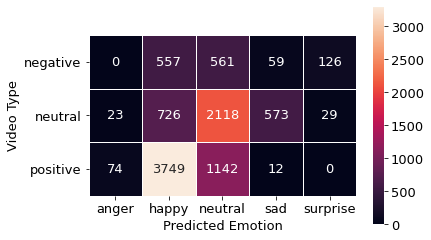

In [23]:
import seaborn as sn
confusion_matrix = pd.crosstab(data_df['video_type'], data_df['pred_emotion'], rownames=['Video Type'], colnames=['Predicted Emotion'])

sn.heatmap(confusion_matrix, annot=True,linewidths=1, robust=True, square=True, fmt='d')
# sn.heatmap(confusion_matrix, annot=True,linewidths=1, vmin=0.0, vmax=1000.0)
plt.show()

In [45]:
for i, emotion in enumerate(data_df['pred_emotion'].unique().tolist()):
    print('Mean RPM of '+ emotion.capitalize() + ':   %f' %data_df.loc[data_df['pred_emotion']== emotion]['rpm'].mean())

Mean RPM of Neutral:   17.313429
Mean RPM of Happy:   17.828160
Mean RPM of Anger:   13.217591
Mean RPM of Sad:   15.198951
Mean RPM of Surprise:   18.294783


In [217]:
from datetime import datetime
fmt = '%Y-%m-%d %H:%M:%S'

# Getting all video data of participant 1
df = data_df.loc[data_df['participant_id'] == str(1)]

# Grabbing start and stop times for all videos of the current participant
ts_first = datetime.strptime(df['rounded_ts'].iloc[0], fmt)
ts_last= datetime.strptime(df['rounded_ts'].iloc[-1], fmt)

# Time Delta
td = int((ts_last-ts_first).total_seconds())

# Creating Time Range
time_range = np.linspace(0, td, num=len(df['rpm'].tolist()))

# Plot rpm over time series

## matplotlib version
# plt.plot(time_range, df['rpm'].tolist())      
# fig = px.line(, x="time", y="rpm", title='RPM Delta')
# fig.show()


## Plotly version
emote_labels = df['pred_emotion']
y = df['rpm'].tolist()
dy = np.diff(y)

fig = go.Figure()

fig.add_trace(go.Scatter(x=time_range, y = y,
                    mode='lines',
                    # mode='lines+text',
                    # text=emote_labels,
                    name='lines'))

#add labels


fig.add_annotation(x=2, y=5,
            text="Text annotation with arrow",
            showarrow=True,
            arrowhead=1)

emote_labels = df['pred_emotion']

fig.add_trace(go.Scatter(
    x=neut_idx,
    y=neutral_df['rpm'].tolist(),
    mode="lines+text",
    name="Lines and Text",
    text=emote_labels,
    textposition="bottom center"


fig.add_trace(go.Scatter(x=time_range, y = dy,
                    mode='lines',
                    name='lines'))
fig.show()


# Add markers for pred_emotion labels

# Show slope

SyntaxError: invalid syntax (<ipython-input-217-c96008252146>, line 57)

In [214]:
# Get list of all emotions
emotion_list = data_df['pred_emotion'].unique().tolist()
# Build DF for only emotion
neutral_df = df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == 'neutral']

neut_idx = []
neut_rpm = []
for ts in neutral_df['rounded_ts'].tolist():
    idx = (ts_last - datetime.strptime(ts,fmt))
    idx = int(idx.total_seconds())
    print(idx)
    neut_idx.append(idx)
neutral_df['rpm'].tolist()

693
693
691
622
622
622


[12.9408, 12.9408, 12.9408, 8.32764, 8.32764, 8.32764]

,rounded_ts,rpm,pred_emotion
46,2021-04-28 17:24:56,12.94080,neutral
47,2021-04-28 17:24:56,12.94080,neutral
48,2021-04-28 17:24:58,12.94080,neutral
60,2021-04-28 17:26:07,8.32764,neutral
61,2021-04-28 17:26:07,8.32764,neutral
62,2021-04-28 17:26:07,8.32764,neutral


In [191]:
# df = data_df.loc[data_df['participant_id'] == str(1)]
emotion_list = data_df['pred_emotion'].unique().tolist()


# df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == 'neutral']
index =[]
emo_list = pd.Series()
for emotion in emotion_list:
    tmp_emo_list = df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == emotion]['pred_emotion']
    emo_list.append(tmp_emo_list)

# for ts in df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == emotion]['rounded_ts'].tolist():
#     idx = (ts_last - datetime.strptime(ts,fmt))
#     idx = int(idx.total_seconds())
#     index.append(idx)
    
# emotion_list, df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == 'neutral'], index
tmp_list = list(zip(tmp_emo_list, index))
emo_list

<ipython-input-191-aa710cf0a1b8>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Series([], dtype: float64)

In [192]:
df[['rounded_ts','rpm','pred_emotion']].loc[df['pred_emotion'] == emotion]['pred_emotion']



46      neutral
47      neutral
48      neutral
60      neutral
61      neutral
         ...   
999       anger
1000      anger
1001      anger
1002      anger
1574      happy
Name: pred_emotion, Length: 686, dtype: object